## Goal: Build a classification model to predict spend range for tech companies

## Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA

In [2]:
comp = pd.read_csv("competitive_master.csv")

In [3]:
comp.describe()

,Unnamed: 0,Rank,Revenue_Billion,Financial Year,Employees,Market cap_Billion,Founded,DMA_Code,IsTop31,Total Persons 12+,Month,Spend_K,Year
count,2.159350e+05,215935.000000,215935.000000,215935.000000,215935.000000,212657.000000,215935.000000,215935.000000,215935.000000,2.159350e+05,215935.000000,215935.000000,215935.000000
mean,5.492127e+05,9.805923,114.270432,2017.988617,247026.083641,533.907453,1997.172256,590.466909,0.317308,1.812687e+07,6.893510,44.377307,2018.472230
std,2.986108e+05,12.567042,108.225244,0.106083,290389.640669,415.688519,6.668268,177.225032,0.465430,6.331413e+07,3.438027,708.473195,0.499229
min,0.000000e+00,1.000000,1.050000,2017.000000,1700.000000,0.300000,1981.000000,0.000000,0.000000,8.100000e+03,1.000000,0.000000,2018.000000
25%,3.040425e+05,1.000000,10.500000,2018.000000,20000.000000,100.400000,1994.000000,524.000000,0.000000,8.832000e+05,4.000000,0.000000,2018.000000
50%,5.497940e+05,2.000000,120.800000,2018.000000,103549.000000,791.010000,1998.000000,577.000000,0.000000,1.991600e+06,7.000000,0.000000,2018.000000
75%,8.135210e+05,15.000000,253.900000,2018.000000,647500.000000,972.340000,1999.000000,679.000000,1.000000,4.226900e+06,10.000000,0.300000,2019.000000
max,1.037422e+06,53.000000,253.900000,2018.000000,647500.000000,972.340000,2011.000000,881.000000,1.000000,2.816179e+08,12.000000,91324.500000,2019.000000


In [4]:
comp.columns

Index(['Unnamed: 0', 'INDUSTRY', 'PARENT', 'ADVERTISER', 'BRAND', 'MARKET',
       'MEDIA', 'Company', 'Rank', 'Revenue_Billion', 'Financial Year',
       'Employees', 'Market cap_Billion', 'Founded', 'DMA_Code', 'NIELSEN DMA',
       'Region_Name', 'Division_Name', 'IsTop31', ' Total Persons 12+ ',
       'Month', 'Spend_K', 'Year'],
      dtype='object')

In [5]:
comp=comp.drop('Unnamed: 0', axis=1)

In [6]:
comp=comp.rename(columns={" Total Persons 12+ ":"Audience Population"})

## Data Exploration

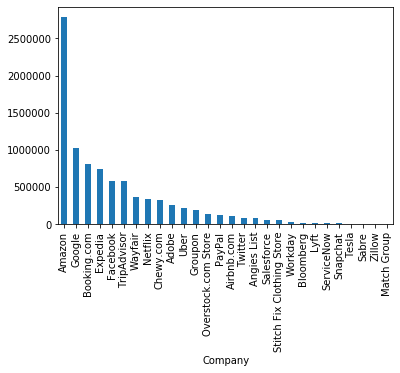

In [7]:
#Competitor's National Advertising Spend Rank

comp[comp['DMA_Code']==0].groupby(['Company'])['Spend_K'].sum().sort_values(ascending=False).plot.bar()

In [8]:
national_spend = comp[(comp['DMA_Code']==0) & (comp['Year']==2018)].groupby(['Company'])['Spend_K'].sum()
avg_revenue = comp[comp['Year']==2018].groupby(['Company'])['Revenue_Billion'].mean()
nat_spend_revenue_ratio = national_spend/avg_revenue/1000000

In [9]:
nat_spend_revenue_ratio.head()

Company
Adobe          0.013870
Airbnb.com     0.020704
Amazon         0.004741
Angies List    0.029709
Bloomberg      0.001041
dtype: float64

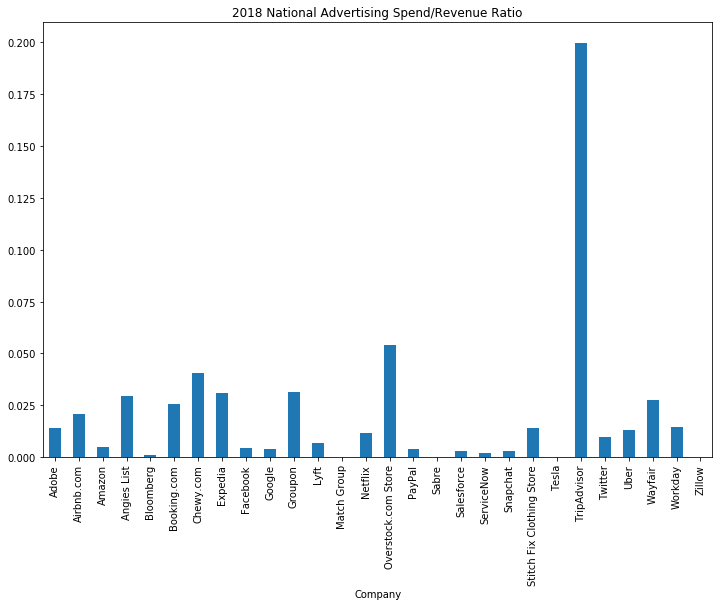

In [10]:
nat_spend_revenue_ratio.plot.bar(figsize=(12,8),title='2018 National Advertising Spend/Revenue Ratio')

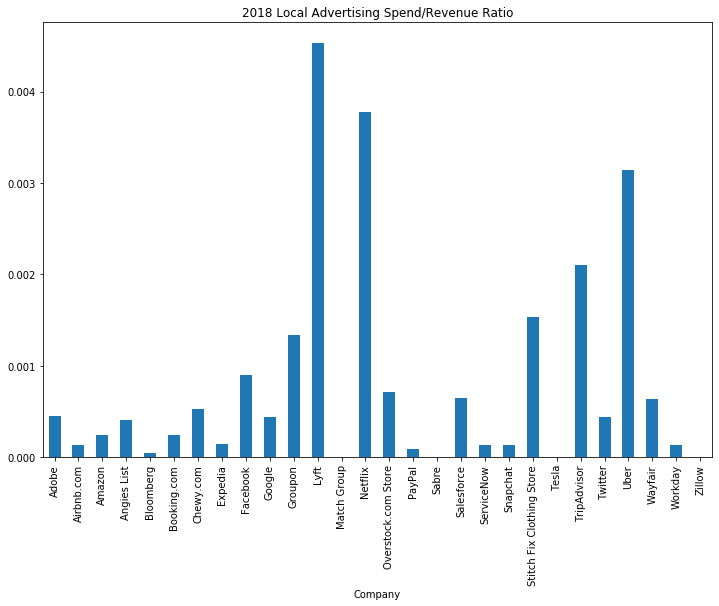

In [11]:
local_spend = comp[(comp['DMA_Code']!=0) & (comp['Year']==2018)].groupby(['Company'])['Spend_K'].sum()
avg_revenue = comp[comp['Year']==2018].groupby(['Company'])['Revenue_Billion'].mean()
local_spend_revenue_ratio = local_spend/avg_revenue/1000000
local_spend_revenue_ratio.plot.bar(figsize=(12,8),title='2018 Local Advertising Spend/Revenue Ratio')

Insight: TripAdvisor spent largest % of their revenue in National advertising, while Lyft, Uber and Netflix spent more in local markets because their marketing efforts are more market-diven

Text(0.5, 1.0, 'Annual Revenue')

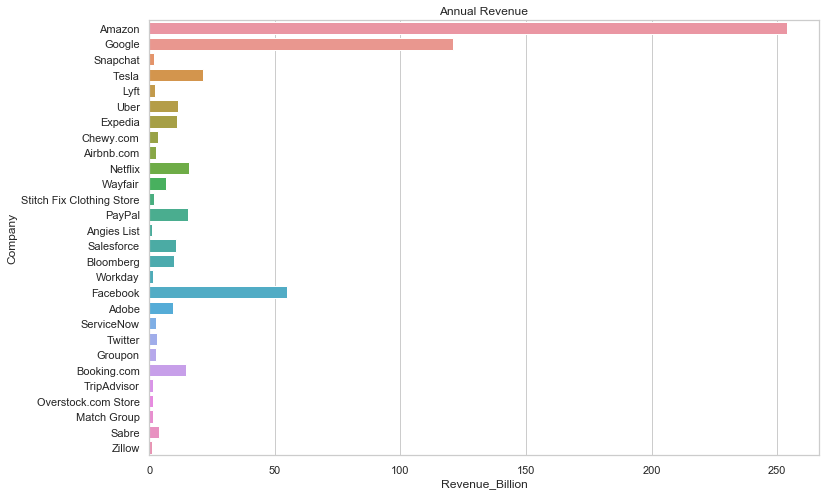

In [12]:
plt.figure(figsize=(12,8))
sns.set(style='whitegrid')
ax = sns.barplot(y='Company', x='Revenue_Billion', data=comp)
plt.title('Annual Revenue')

Add more charts on Media Mix, Market Distribution later


## Data Processing

In [13]:
comp.describe()

,Rank,Revenue_Billion,Financial Year,Employees,Market cap_Billion,Founded,DMA_Code,IsTop31,Audience Population,Month,Spend_K,Year
count,215935.000000,215935.000000,215935.000000,215935.000000,212657.000000,215935.000000,215935.000000,215935.000000,2.159350e+05,215935.000000,215935.000000,215935.000000
mean,9.805923,114.270432,2017.988617,247026.083641,533.907453,1997.172256,590.466909,0.317308,1.812687e+07,6.893510,44.377307,2018.472230
std,12.567042,108.225244,0.106083,290389.640669,415.688519,6.668268,177.225032,0.465430,6.331413e+07,3.438027,708.473195,0.499229
min,1.000000,1.050000,2017.000000,1700.000000,0.300000,1981.000000,0.000000,0.000000,8.100000e+03,1.000000,0.000000,2018.000000
25%,1.000000,10.500000,2018.000000,20000.000000,100.400000,1994.000000,524.000000,0.000000,8.832000e+05,4.000000,0.000000,2018.000000
50%,2.000000,120.800000,2018.000000,103549.000000,791.010000,1998.000000,577.000000,0.000000,1.991600e+06,7.000000,0.000000,2018.000000
75%,15.000000,253.900000,2018.000000,647500.000000,972.340000,1999.000000,679.000000,1.000000,4.226900e+06,10.000000,0.300000,2019.000000
max,53.000000,253.900000,2018.000000,647500.000000,972.340000,2011.000000,881.000000,1.000000,2.816179e+08,12.000000,91324.500000,2019.000000


In [14]:
comp.columns

Index(['INDUSTRY', 'PARENT', 'ADVERTISER', 'BRAND', 'MARKET', 'MEDIA',
       'Company', 'Rank', 'Revenue_Billion', 'Financial Year', 'Employees',
       'Market cap_Billion', 'Founded', 'DMA_Code', 'NIELSEN DMA',
       'Region_Name', 'Division_Name', 'IsTop31', 'Audience Population',
       'Month', 'Spend_K', 'Year'],
      dtype='object')

In [15]:
#Remove Industry, Parent, Advertiser, Brand, Nielsen DMA, Region Name

comp_df = pd.pivot_table(comp, values=['BRAND','Rank','Revenue_Billion','Employees','Market cap_Billion','Founded','IsTop31','Audience Population','Spend_K'],
                        index = ['Company','DMA_Code','MEDIA','Division_Name','Year','Month'],
                        aggfunc={'BRAND':'count', 'Rank':np.mean, 'Revenue_Billion':np.mean, 'Employees':np.mean, 'Market cap_Billion':np.mean, 'Founded':np.mean,'Audience Population': np.mean,'Spend_K':np.sum, 'IsTop31': np.mean })

In [16]:
comp_df = comp_df.reset_index()

There is a huge gap between National Spend and Local Spend. To get more accurate and reasonable mode, we separate National and Local. 

In [17]:
#turn DMA_Code, IsTop31 to Categorical values
comp_df['DMA_Code'] = comp_df['DMA_Code'].astype('category')
comp_df['IsTop31'] = comp_df['IsTop31'].astype('category')

In [18]:
#duplicate Rank as Company ID 
comp_df['Company_ID']=comp_df['Rank'].astype('category')

In [19]:
#Create dummies for MEDIA and Division
media = pd.get_dummies(comp_df['MEDIA'], prefix='Media')
division = pd.get_dummies(comp_df['Division_Name'], prefix='Div')

In [20]:
comp_df_new = pd.concat([comp_df, media, division],axis=1)

In [21]:
comp_df_new.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
0,Adobe,0,B-to-B,National,2018,1,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
1,Adobe,0,B-to-B,National,2018,4,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
2,Adobe,0,B-to-B,National,2018,8,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
3,Adobe,0,B-to-B,National,2018,9,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
4,Adobe,0,B-to-B,National,2018,10,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0


### National Spend data set

In [22]:
nat_comp_df = comp_df_new[comp_df_new['DMA_Code']==0]
nat_comp_df.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
0,Adobe,0,B-to-B,National,2018,1,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
1,Adobe,0,B-to-B,National,2018,4,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
2,Adobe,0,B-to-B,National,2018,8,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
3,Adobe,0,B-to-B,National,2018,9,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0
4,Adobe,0,B-to-B,National,2018,10,281617900,1,21200,1982,...,0,0,0,0,0,0,0,1,0,0


In [23]:
nat_comp_df = nat_comp_df.drop(columns=['Company','Div_ALL OTHER','Div_Central','Div_National','Div_Northeast','Div_West','Division_Name','MEDIA','DMA_Code'], axis=1)

#### Create Bins for Spend_K

In [24]:
nat_comp_df.Spend_K.quantile(list(np.linspace(0,1,11)))

0.0        0.00
0.1        6.10
0.2       29.48
0.3       86.60
0.4      192.34
0.5      399.95
0.6      737.60
0.7     1376.33
0.8     2490.18
0.9     6015.89
1.0    92615.30
Name: Spend_K, dtype: float64

In [25]:
#75% values are between 0 to 12000
BINS = [0,10,30,50,80,100,150,200,400,600,800,1000,1500,2000,3000,5000,8000,10000,15000,100000]

In [26]:
nat_comp_df['Spend_Bins'] = pd.cut(x=nat_comp_df.Spend_K, bins=BINS, labels=False)

In [27]:
nat_comp_df['Spend_Bins']

0        7.0
1        0.0
2        7.0
3        7.0
4        9.0
        ... 
95727    0.0
95728    0.0
95729    0.0
95730    0.0
95731    1.0
Name: Spend_Bins, Length: 3578, dtype: float64

In [28]:
nat_comp_df = nat_comp_df.drop('Spend_K', axis=1)

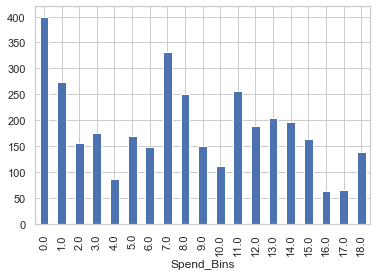

In [29]:
nat_comp_df.groupby('Spend_Bins')['BRAND'].count().plot.bar()

In [30]:
#Remove all NAs
nat_comp_df = nat_comp_df.dropna(how='any')

### Local Market Level Spend Data

In [31]:
local_df = comp_df_new[comp_df_new['DMA_Code']!=0]
local_df.head()

,Company,DMA_Code,MEDIA,Division_Name,Year,Month,Audience Population,BRAND,Employees,Founded,...,Media_Outdoor,Media_SLN TV,Media_Spot TV,Media_Sunday Mags,Media_Syndication,Div_ALL OTHER,Div_Central,Div_National,Div_Northeast,Div_West
118,Adobe,500,Int Display,Northeast,2018,1,892300,5,21200,1982,...,0,0,0,0,0,0,0,0,1,0
119,Adobe,500,Int Display,Northeast,2018,2,892300,6,21200,1982,...,0,0,0,0,0,0,0,0,1,0
120,Adobe,500,Int Display,Northeast,2018,3,892300,6,21200,1982,...,0,0,0,0,0,0,0,0,1,0
121,Adobe,500,Int Display,Northeast,2018,4,892300,6,21200,1982,...,0,0,0,0,0,0,0,0,1,0
122,Adobe,500,Int Display,Northeast,2018,5,892300,5,21200,1982,...,0,0,0,0,0,0,0,0,1,0


In [32]:
local_df.Spend_K.quantile(list(np.linspace(0,1,11)))

0.0       0.0
0.1       0.0
0.2       0.0
0.3       0.0
0.4       0.0
0.5       0.1
0.6       0.2
0.7       0.5
0.8       1.4
0.9       6.0
1.0    2390.1
Name: Spend_K, dtype: float64

Local Spend looks very umbalanced and minimal compared to National Spend. We will focus on National Spend first. d

## Training, testing and cross-validation

In [33]:
#Split the data into training and test sets
y = nat_comp_df['Spend_Bins']
X = nat_comp_df.drop('Spend_Bins', axis=1)

In [34]:
y

0        7.0
1        0.0
2        7.0
3        7.0
4        9.0
        ... 
95727    0.0
95728    0.0
95729    0.0
95730    0.0
95731    1.0
Name: Spend_Bins, Length: 3306, dtype: float64

### Standaridize the data set

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
scaled_features = pd.DataFrame(scaled, columns=X.columns)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size=0.25, random_state=4)

### Build the Base Model

In [37]:
#Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
forest.score(X_train, y_train)

0.9588543767648245

In [39]:
forest.score(X_test, y_test)

0.30350665054413545

The mean accuracy on the test set is much lower than the training set. Let's try testing out different hyperparameters!

### Grid Search

In [40]:
forest_grid = {
    'n_estimators':[5,10,15,20,25,30],
    'criterion':['gini','entropy'],
    
    'min_samples_split':[2,5,10,20],
    'class_weight':['balanced', 'balanced_subsample',None]
      
}

In [41]:
forest_grid_search = GridSearchCV(forest, forest_grid, cv=3, return_train_score = True, n_jobs=1)
forest_grid_search.fit(X_train, y_train)

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [42]:
# Mean training score
forest_gs_training_score = np.mean(forest_grid_search.cv_results_['mean_train_score'])

# Mean test score
forest_gs_testing_score = forest_grid_search.score(X_test, y_test)

print("Mean Training Score: ", forest_gs_training_score)
print("Mean Test Score: " , forest_gs_testing_score)
print("Best Parameter Combination Found During Grid Search:")
forest_grid_search.best_estimator_
forest_grid_search.best_params_

Mean Training Score:  0.6853845537421519
Mean Test Score:  0.3180169286577993
Best Parameter Combination Found During Grid Search:


{'class_weight': None,
 'criterion': 'entropy',
 'min_samples_split': 5,
 'n_estimators': 25}

The training score is worse than the baseline, but the test score is just slightly higher than the baseline.

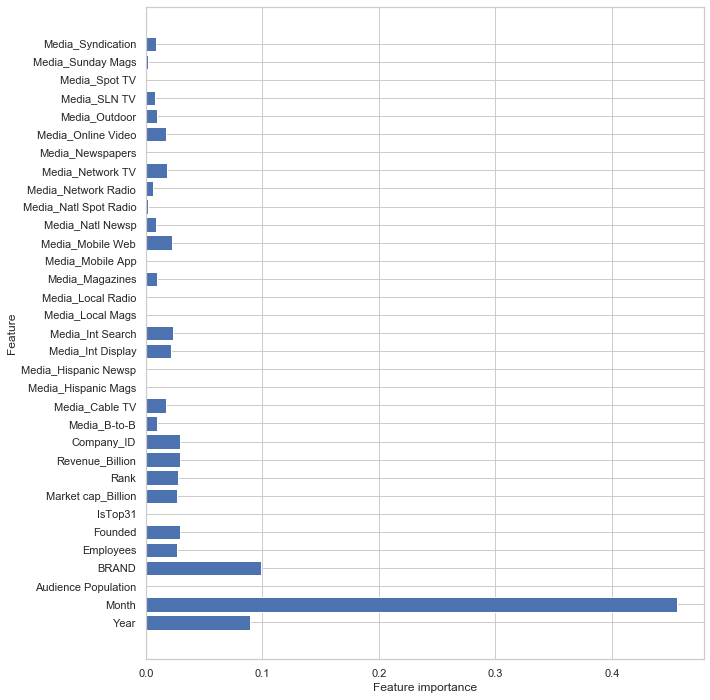

In [43]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


plot_feature_importances(forest)

Year and Month, Number of Brands play a big role in determining the spend

### Incoporate PCA

PCA plays a key roles in reducing the number of dimensions, preserving the essence of the original data. There is a way to choose n_components - check the explained variance. 

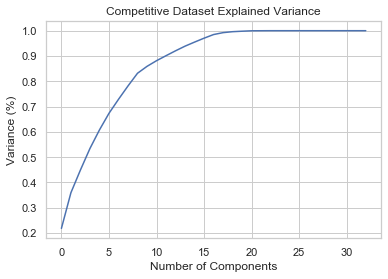

In [44]:
#Fit the PCA with scaled data
pca = PCA().fit(scaled_features)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.title('Competitive Dataset Explained Variance')
plt.show()

This suggests that selecting 15 or 16 components we can preserve around 97% to 99% of the total variance of the data. 

**Check important features after PCA**

In [45]:

np.random.seed(0)

pca = PCA(n_components=15).fit(scaled_features)

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = scaled_features.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [46]:
df

,0,1
0,PC0,Market cap_Billion
1,PC1,Year
2,PC2,Media_Int Display
3,PC3,Media_Mobile Web
4,PC4,Media_Online Video
5,PC5,Media_Cable TV
6,PC6,Month
7,PC7,Company_ID
8,PC8,Media_Network TV
9,PC9,Media_Network TV


In [47]:
pca=PCA(n_components=15)
pca_dataset = pca.fit_transform(scaled_features)

In [48]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(pca_dataset, y, test_size=0.25, random_state=4)

In [49]:
forest_2 = RandomForestClassifier(criterion = 'entropy', min_samples_split=5)
forest_2.fit(X_train_2, y_train_2)

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [50]:
forest_2.score(X_train_2, y_train_2)

0.8656716417910447

In [51]:
forest_2.score(X_test_2, y_test_2)

0.3059250302297461

### TRY PIPELINE!!!

In [52]:
#Create the pipeline and include PCA in the process
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipe = Pipeline([
                ('pca', PCA(n_components=15)),
                ('tree', RandomForestClassifier())])

# Create the grid parameter
grid = [{'tree__n_estimators':[5,10,15,20,25,30],
    'tree__criterion':['gini','entropy'],
    'tree__max_depth':[None,5,8,10,13],
    'tree__min_samples_split':[2,5,10,20]}]

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch.fit(X_train_2, y_train_2)

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=15, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('tree',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                             

In [55]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

## KEEP IT FOR NOW
# Construct some pipelines
pipe_svm = Pipeline([('pca', PCA(n_components=15)),
        ('clf', svm.SVC(random_state=123))])
        
pipe_tree = Pipeline([('pca', PCA(n_components=15)),
        ('clf', tree.DecisionTreeClassifier(random_state=123))])

pipe_rf = Pipeline([('pca', PCA(n_components=15)),
        ('clf', RandomForestClassifier(random_state=123))])

# List of pipelines, List of pipeline names
pipelines = [pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['Support Vector Machine','Decision Tree','Random Forest']

# Loop to fit each of the three pipelines
for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train_2, y_train_2)

# Compare accuracies
for index, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test_2, y_test_2)))

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=123, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)


C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=15,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=123,
                                        splitter='best'))],
         verbose=False)
Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto',

C:\Users\bonma1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Support Vector Machine pipeline test accuracy: 0.192
Decision Tree pipeline test accuracy: 0.252
Random Forest pipeline test accuracy: 0.279


### Random Forest still has the best performance

### Visualize Feature Importance 

https://github.com/gaurav-kaushik/Data-Visualizations-Medium/blob/master/code/Interactive_PCA_and_Feature_Correlation.ipynb

In [56]:

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from itertools import cycle
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
import warnings
warnings.filterwarnings(action='ignore')
output_notebook()
%matplotlib inline

Loading BokehJS ...

In [57]:
def get_float_list(range_max:int, div:int=100) -> list:
    """ To get 0 -> 1, range_max must be same order of mag as div """
    return [float(x)/div for x in range(int(range_max))]


def get_colorcycle(colordict:dict):
    """ Subset cnames with a string match and get a color cycle for plotting """
    return cycle(list(colordict.keys()))


def get_colordict(filter_:str='dark') -> dict:
    """ return dictionary of colornames by filter """
    return dict((k, v) for k, v in cnames.items() if filter_ in k)


def pca_report_interactive(X, scale_X:bool=True, save_plot:bool=False):
    """
    X:          input data matrix
    scale_X:    determine whether to rescale X (StandardScaler) [default: True, X is not prescaled
    save_plot:  save plot to file (html) and not show
    """

    # calculate mean and var
    X_mean, X_var = X.mean(), X.var()
    print('\n*--- PCA Report ---*\n')
    print(f'X mean:\t\t{X_mean:.3f}\nX variance:\t{X_var:.3f}')

    if scale_X:
        # rescale and run PCA
        print("\n...Rescaling data...\n")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_s_mean, X_s_var = X_scaled.mean(), X_scaled.var()
        print(f'X_scaled mean:\t\t{np.round(X_s_mean):.3f}')
        print(f'X_scaled variance:\t{np.round(X_s_var):.3f}\n')
        pca_ = PCA().fit(X_scaled)
        X_pca = PCA().fit_transform(X)
    else:
        # run PCA directly
        print("...Assuming data is properly scaled...")
        pca_ = PCA().fit(X)
        X_pca = PCA().fit_transform(X)
            
    # Get cumulative explained variance for each dimension
    pca_evr = pca_.explained_variance_ratio_
    cumsum_ = np.cumsum(pca_evr)
    
    # Get dimensions where var >= 95% and values for variance at 2D, 3D
    dim_95 = np.argmax(cumsum_ >= 0.95) + 1
    twoD = np.round(cumsum_[1], decimals=3)*100 
    threeD = np.round(cumsum_[2], decimals=3)*100
    instances_, dims_ =  X.shape
    
    # check shape of X
    if dims_ > instances_:
        print("WARNING: number of features greater than number of instances.")
        dimensions = list(range(1, instances_+1))
    else:
        dimensions = list(range(1, dims_+1))
    
    # Print report
    print("\n -- Summary --")
    print(f"You can reduce from {dims_} to {dim_95} dimensions while retaining 95% of variance.")
    print(f"2 principal components explain {twoD:.2f}% of variance.")
    print(f"3 principal components explain {threeD:.2f}% of variance.")
    
    """ - Plotting - """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['PCA'], tooltips=[("dimensions", "@x_dim"), 
                                                ("cumulative variance", "@y_cumvar"),
                                                ("explained variance", "@y_var")])
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # insert 0 at beginning for cleaner plotting
    cumsum_plot = np.insert(cumsum_, 0, 0) 
    pca_evr_plot = np.insert(pca_evr, 0, 0)
    dimensions_plot = np.insert(dimensions, 0, 0)

    """
    ColumnDataSource
    - a special type in Bokeh that allows you to store data for plotting
    - store data as dict (key:list)
    - to plot two keys against one another, make sure they're the same length!
    - below:
        x_dim    # of dimensions (length = # of dimensions)
        y_cumvar # cumulative variance (length = # of dimensions)
        var_95   # y = 0.95 (length = # of dimensions)
        zero_one # list of 0 to 1
        twoD     # x = 2 
        threeD   # x = 3 
    """ 
    
    # get sources
    source_PCA = ColumnDataSource(data=dict(x_dim = dimensions_plot,y_cumvar = cumsum_plot, y_var = pca_evr_plot))    
    source_var95 = ColumnDataSource(data=dict(var95_x = [dim_95]*96, var95_y = get_float_list(96)))
    source_twoD = ColumnDataSource(data=dict(twoD_x = [2]*(int(twoD)+1), twoD_y = get_float_list(twoD+1)))
    source_threeD = ColumnDataSource(data=dict(threeD_x = [3]*(int(threeD)+1), threeD_y = get_float_list(threeD+1)))

    """ PLOT """
    # set up figure and add axis labels
    p = figure(title='PCA Analysis', tools=p_tools)
    p.xaxis.axis_label = f'N of {dims_} Principal Components' 
    p.yaxis.axis_label = 'Variance Explained (per PC & Cumulative)'
    
    # add reference lines: y=0.95, x=2, x=3
    p.line('twoD_x', 'twoD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_twoD) # x=2
    p.line('threeD_x', 'threeD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_threeD) # x=3
    p.line('var95_x', 'var95_y', line_width=2, line_dash='dotted', color='#435363', source=source_var95) # var = 0.95

    # add bar plot for variance per dimension
    p.vbar(x='x_dim', top='y_var', width=.5, bottom=0, color='#D9F2EF', source=source_PCA, name='PCA')
    
    # add cumulative variance (scatter + line)
    p.line('x_dim', 'y_cumvar', line_width=1, color='#F79737', source=source_PCA)
    p.circle('x_dim', 'y_cumvar', size=7, color='#FF4C00', source=source_PCA, name='PCA')

    # change gridlines
    p.ygrid.grid_line_alpha = 0.25
    p.xgrid.grid_line_alpha = 0.25

    # change axis bounds and grid
    p.xaxis.bounds = (0, dims_)
    p.yaxis.bounds = (0, 1)
    p.grid.bounds = (0, dims_)

    # save and show p
    if save_plot:
        output_file('PCA_analysis.html')
    show(p)
        
    # output PCA info as a dataframe
    df_PCA = pd.DataFrame({'dimension': dimensions, 'variance_cumulative': cumsum_, 'variance': pca_evr}).set_index(['dimension'])
        
    return df_PCA, X_pca, pca_evr


def pca_feature_correlation(X, X_pca, explained_var, features:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    1. Get dot product of X and X_pca
    2. Run normalizations of X*X_pca
    3. Retrieve df/matrices

    X:               data (numpy matrix)
    X_pca:           PCA
    explained_var:   explained variance matrix
    features:        list of feature names
    fig_dpi:         dpi to use for heatmaps
    save_plot:       save plot to file (html) and not show
    """
    
    # Add zeroes for data where features > instances
    outer_diff = X.T.shape[0] - X_pca.shape[1]
    if outer_diff > 0: # outer dims must match to get sq matrix
        Z = np.zeros([X_pca.shape[0], outer_diff])
        X_pca = np.c_[X_pca, Z]
        explained_var = np.append(explained_var, np.zeros(outer_diff))
    
    # Get correlation between original features (X) and PCs (X_pca)
    dot_matrix = np.dot(X.T, X_pca)
    print(f"X*X_pca: {X.T.shape} * {X_pca.shape} = {dot_matrix.shape}")
    
    # Correlation matrix -> df
    df_dotproduct = pd.DataFrame(dot_matrix)
    df_dotproduct.columns = [''.join(['PC', f'{i+1}']) for i in range(dot_matrix.shape[0])]
    if any(features): df_dotproduct.index = features    
    
    # Normalize & Sort
    df_n, df_na, df_nabv = normalize_dataframe(df_dotproduct, explained_var, plot_opt=True, save_plot=save_plot)
    
    return df_dotproduct, df_n, df_na, df_nabv


def normalize_dataframe(df, explained_var=None, fig_dpi:int=150, plot_opt:bool=True, save_plot:bool=False):
    """
    1. Get z-normalized df (normalized to µ=0, σ=1)
    2. Get absolute value of z-normalized df
    3. If explained_variance matrix provided, dot it w/ (2)
    """
    # Normalize, Reindex, & Sort
    df_norm = (df.copy()-df.mean())/df.std()
    df_norm = df_norm.sort_values(list(df_norm.columns), ascending=False)
    
    # Absolute value of normalized (& sort)
    df_abs = df_norm.copy().abs().set_index(df_norm.index)
    df_abs = df_abs.sort_values(by=list(df_abs.columns), ascending=False)
    
    # Plot
    if plot_opt:
        # Z-normalized corr matrix
        plt.figure(dpi=fig_dpi)
        ax_normal = sns.heatmap(df_norm, cmap="RdBu")
        ax_normal.set_title("Z-Normalized Data")
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix.png')
        else:
            plt.show()

        # |Z-normalized corr matrix|  
        plt.figure(dpi=fig_dpi)
        ax_abs = sns.heatmap(df_abs, cmap="Purples")
        ax_abs.set_title("|Z-Normalized|")
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix_Abs.png')
        else:
            plt.show()
        
    # Re-normalize by explained var (& sort)
    if explained_var.any():
        df_byvar = df_abs.copy()*explained_var
        df_byvar = df_byvar.sort_values(by=list(df_norm.columns), ascending=False)
        if plot_opt:
            plt.figure(dpi=fig_dpi)
            ax_relative = sns.heatmap(df_byvar, cmap="Purples")
            ax_relative.set_title("|Z-Normalized|*Explained_Variance")
            if save_plot:
                plt.savefig('Normalized_corr_matrix.png')
            else:
                plt.show()
    else:
        df_byvar = None
    return df_norm, df_abs, df_byvar


def pca_rank_features(df_nabv, verbose:bool=True):
    """
    Given a dataframe df_nabv with dimensions [f, p], where:
        f = features (sorted)
        p = principal components
        df_nabv.values are |Z-normalized X|*pca_.explained_variance_ratio_
        
    1. Create column of sum of each row, sort by it 'score_'
    3. Set index as 'rank'
    """
    df_rank = df_nabv.copy().assign(score_ = df_nabv.sum(axis=1)).sort_values('score_', ascending=False)
    df_rank['feature_'] = df_rank.index
    df_rank.index = range(1, len(df_rank)+1)
    df_rank.drop(df_nabv.columns, axis=1, inplace=True)
    df_rank.index.rename('rank', inplace=True)
    if verbose: print(df_rank)
    return df_rank


def pca_full_report(X, features_:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    Run complete PCA workflow:
        1. pca_report_interactive()
        2. pca_feature_correlation()
        3. pca_rank_features()
        
    X:            data (numpy array)
    features_:    list of feature names
    fig_dpi:      image resolution
    
    """
    # Retrieve the interactive report
    df_pca, X_pca, pca_evr = pca_report_interactive(X, save_plot=save_plot)
    # Get feature-PC correlation matrices
    df_corr, df_n, df_na, df_nabv = pca_feature_correlation(X, X_pca, pca_evr, features_, fig_dpi, save_plot) 
    # Get rank for each feature
    df_rank = pca_rank_features(df_nabv)
    return (df_pca, X_pca, pca_evr, df_corr, df_n, df_na, df_nabv, df_rank)


*--- PCA Report ---*

X mean:		0.120
X variance:	0.083

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 33 to 20 dimensions while retaining 95% of variance.
2 principal components explain 23.40% of variance.
3 principal components explain 28.40% of variance.


X*X_pca: (33, 3306) * (3306, 33) = (33, 33)


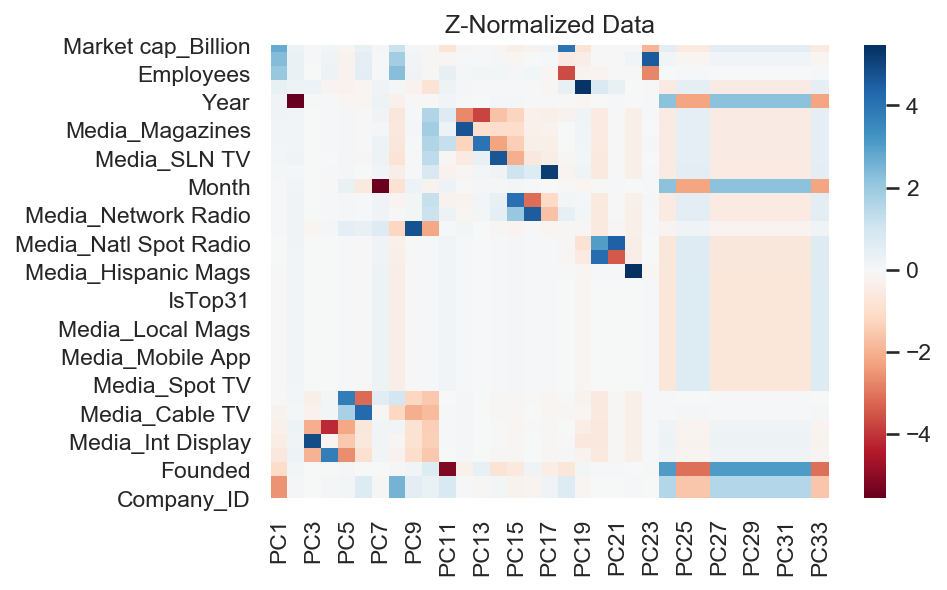

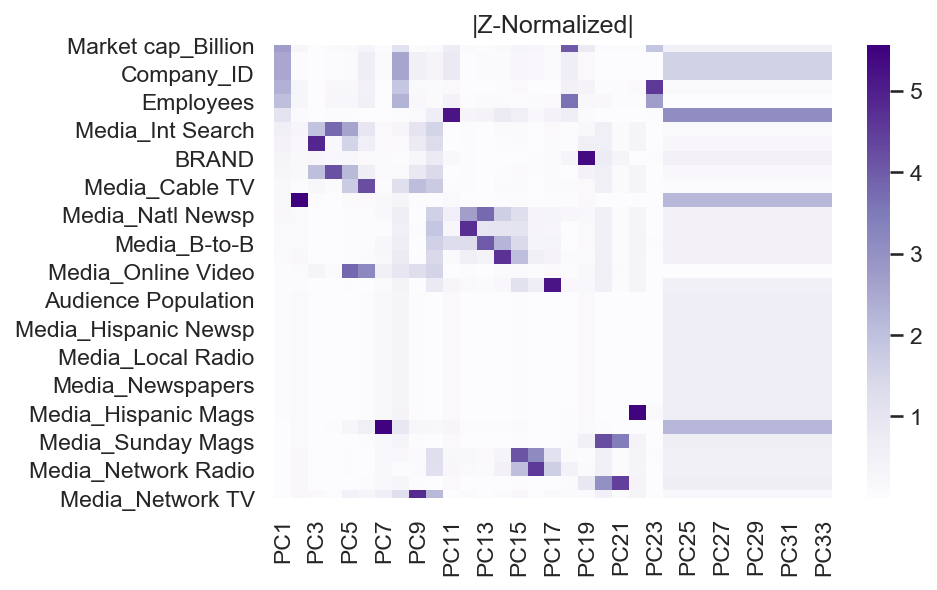

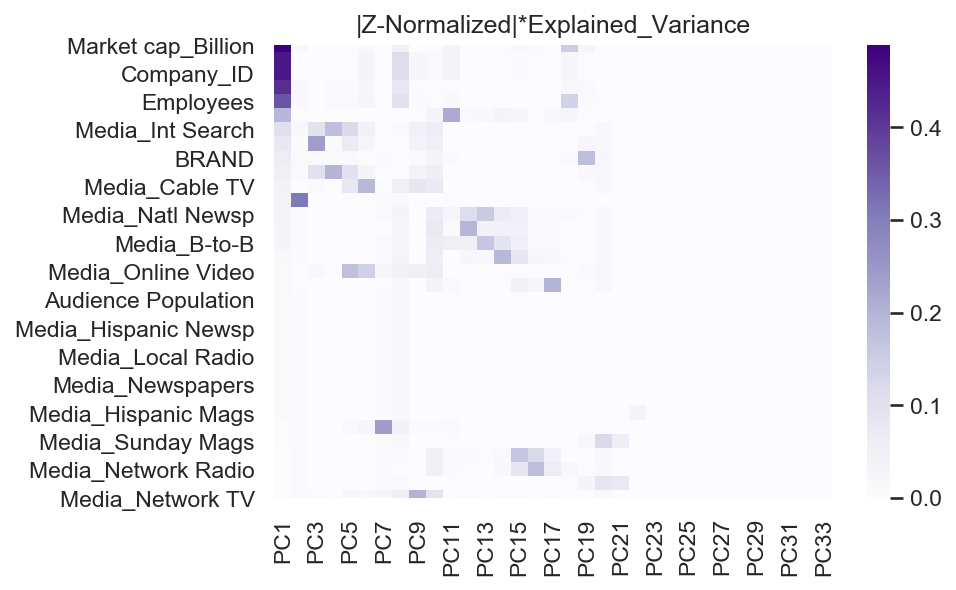

        score_               feature_
rank                                 
1     0.853714     Market cap_Billion
2     0.748783             Company_ID
3     0.748783                   Rank
4     0.737673       Media_Int Search
5     0.737036              Employees
6     0.661593       Media_Mobile Web
7     0.632025       Media_Natl Newsp
8     0.627287           Media_B-to-B
9     0.623707        Revenue_Billion
10    0.606729         Media_Cable TV
11    0.605702      Media_Int Display
12    0.603081                Founded
13    0.601197     Media_Online Video
14    0.542011        Media_Magazines
15    0.528427           Media_SLN TV
16    0.493800    Media_Network Radio
17    0.491081      Media_Syndication
18    0.487461       Media_Network TV
19    0.420448          Media_Outdoor
20    0.420308                  BRAND
21    0.412714                   Year
22    0.397847                  Month
23    0.266437      Media_Sunday Mags
24    0.255563  Media_Natl Spot Radio
25    0.1058

In [58]:
data = pca_dataset
outputs = pca_full_report(X=scaled, features_=scaled_features.columns)